# Sydney Real Estate

The SurfIntoYourHome LLC from Sydney wants to offer a new service to their clients. Similar to the competition from overseas, the company wants to offer a price estimate of a building to their customers. This is supposed to help the customer evaluate wether the pricing of a building is fair or not. In order for the prediction to work the company has provided a dataset under the CC0: Public Domain License from https://www.kaggle.com/datasets/mihirhalai/sydney-house-prices?select=SydneyHousePrices.csv which includes property offerings that have been scraped from realestate.com.au.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from sklearn.metrics import mean_absolute_error
sns.set(rc={'figure.figsize':(20,10)})
import random
random.seed(1)

In [2]:
data = pd.read_csv("data/SydneyHousePrices.csv")# for the server/home/jovyan/DeepLearningExperiment/data/SydneyHousePrices.csv")

In [3]:
data.shape

(199504, 9)

In [4]:
data.head()

,Date,Id,suburb,postalCode,sellPrice,bed,bath,car,propType
0,2019-06-19,1,Avalon Beach,2107,1210000,4.0,2,2.0,house
1,2019-06-13,2,Avalon Beach,2107,2250000,4.0,3,4.0,house
2,2019-06-07,3,Whale Beach,2107,2920000,3.0,3,2.0,house
3,2019-05-28,4,Avalon Beach,2107,1530000,3.0,1,2.0,house
4,2019-05-22,5,Whale Beach,2107,8000000,5.0,4,4.0,house


The dataset contains 199504 rows and has 9 columns.

A typical entry consits of the Date which refers to the date the property has been sold. An Id, the suburb and postal code the property was located in. The price the property was sold for as well as the number of bedrooms bathrooms and number of car parking spaces that belong to it. In addition the type of property is also available. Defining wether the sold object was a house, a townhouse or a villa.

In [5]:
data["sellPrice"].max()

2147483647

In [6]:
data.describe()

,Id,postalCode,sellPrice,bed,bath,car
count,199504.00000,199504.000000,1.995040e+05,199350.000000,199504.000000,181353.000000
mean,99752.50000,2196.379155,1.269776e+06,3.516479,1.890669,1.936224
std,57591.98839,193.053467,6.948239e+06,1.066555,0.926001,1.060237
min,1.00000,2000.000000,1.000000e+00,1.000000,1.000000,1.000000
25%,49876.75000,2082.000000,7.200000e+05,3.000000,1.000000,1.000000
50%,99752.50000,2144.000000,9.850000e+05,3.000000,2.000000,2.000000
75%,149628.25000,2211.000000,1.475000e+06,4.000000,2.000000,2.000000
max,199504.00000,4878.000000,2.147484e+09,99.000000,99.000000,41.000000


The dataset contains property that has been sold for 1 AUD up to 2 billion dollar. This is clearly a mistake and during the data cleaning those extreme values will be removed. the lower values for bedrooms, bathrooms and car parking spots seem plausible as they are all 1. However, the max values for bed and bathrooms of 99 seems implausible. The same applies for the car parking with 41. Even if those values are true the company is focused on singles and families and not real estate developers, therefor those values can be excluded from the prediction.

For this purpose the dataset will be filtered to only keep listings with a price lower than or equal to 4 Mio AUD. For the bedrooms, bathrooms and car parking lots a filter of 10 is applied. 

Because the company gets paid a percentage off the price the property is sold for they are only interested in ones that are valued at a minimum of 500,000 AUD.

In [7]:
data_filtered = data[data["sellPrice"]<= 4000000]
data_filtered = data_filtered[data_filtered["sellPrice"]>= 500000]
data_filtered = data_filtered[data_filtered["bed"]<= 10]
data_filtered = data_filtered[data_filtered["bath"]<= 10]
data_filtered = data_filtered[data_filtered["car"]<= 10]

In [8]:
data_filtered.describe()

,Id,postalCode,sellPrice,bed,bath,car
count,166356.000000,166356.000000,1.663560e+05,166356.000000,166356.000000,166356.000000
mean,98963.169961,2195.212977,1.221979e+06,3.603417,1.949392,1.938187
std,57529.026686,185.510444,6.403501e+05,0.945752,0.833357,0.978318
min,1.000000,2000.000000,5.000000e+05,1.000000,1.000000,1.000000
25%,48374.750000,2090.000000,7.600000e+05,3.000000,1.000000,1.000000
50%,99139.500000,2146.000000,1.020000e+06,4.000000,2.000000,2.000000
75%,149105.250000,2211.000000,1.499125e+06,4.000000,2.000000,2.000000
max,199504.000000,4217.000000,4.000000e+06,10.000000,10.000000,10.000000


The resulting dataset appears to be more plausible now. The average real estate object has now a price of roughly 1,222,000 AUD, which contains 3.6 bedrooms, almost 2 bathrooms and 2 car parking plots. 

As a next step the year of the sale will be extracted as feature. The prices in the sydney are mostlikely be correlated to the year of the sale.


In [9]:
type(data_filtered["Date"][0])

str

The date is saved as string so the year can be extracted rather easily.

In [10]:
data_filtered["year"] = pd.to_numeric(data_filtered["Date"].str[:4])

In [11]:
data_filtered.groupby("year")["sellPrice"].count()

year
2000        1
2001        3
2002        1
2003        6
2004       32
2005       78
2006      110
2007      553
2008     2632
2009     5506
2010     6906
2011     7719
2012     8960
2013    14163
2014    19348
2015    22825
2016    23025
2017    25048
2018    21053
2019     8387
Name: sellPrice, dtype: int64

Because most of the values are in the range from 2009 to 2019, all values before that will be excluded. 2009 will be set as year 1 for the prediction. The idea of setting the date as this type of variable is that in general the housing prices are increasing year over year [2]. This is not always true, as especially in times of crises the prices can drop from the year before. However, most of the time the prices of houses increase year over year. This is especially true for sydney where the housing prices from 2019 to 2022 increased by 55 % [1].

In [12]:
data_filtered = data_filtered[data_filtered["year"]>=2009]

In [13]:
data_filtered["year_norm"] = data_filtered["year"] -2008

<AxesSubplot:xlabel='year', ylabel='sellPrice'>

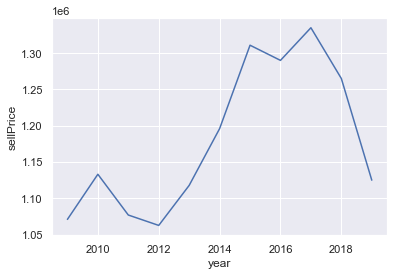

In [14]:
sns.lineplot(x=data_filtered.groupby("year")["sellPrice"].mean().round(0).index[:], y= data_filtered.groupby("year")["sellPrice"].mean().round(0)[:])


The graphic above shows the variation of the average price over the years. The massive drop at the end is most likely due to the fact that the data is collected until june 2019 and so data for the rest of the year is missing. Other than that it looks like prices are increasing over the years. One has to be careful with interpretations here as it is the average sell price and the amount of houses and especially the type of estates being sold may vary from year to year. And thus one year larger and therefor more expensive houses are sold, while other years smaller and cheaper houses make up a grater percentage of the mix. Resulting in misinterpretations from this graphic.


Next the property types will be evaluated.

In [15]:
data_filtered.groupby("propType")["propType"].count()

propType
acreage                     10
duplex/semi-detached      5691
house                   139422
other                      146
terrace                    696
townhouse                12758
villa                     4199
warehouse                   18
Name: propType, dtype: int64

As mentioned before the client is manly interessted in selling housing to people who will actually move in to the property. Therefor warehouses and acreage can be removed as they are not important for this business goal. In addition to this the category other will be removed. This leaves the property types "duplex/semi-detached","house","townhouse","villa", "terrace".

In [16]:
data_filtered = data_filtered[data_filtered["propType"].isin(["duplex/semi-detached","house","townhouse","villa", "terrace"])]

As a last step the location will be taken into consideration. Location is most likely one key factor of the price of housing. There are two possible features that can be used to take this into consideration. Option one is to use the suburb. The problem here is that there are 669 unique suburbs in the dataset. This is most likely to fine in granularity. Therefor two datasets will be generated. One with the raw suburbs as input and one with the suburbs clustered with the average number of bedrooms, bathrooms and average price of the suburb. The second option from the dataset is to use the ZIP code. This, however, is not as fine in granularity and therefor most likely not as well suited for this analysis. ZIP codes will be dropped later.

In [17]:

data_all_suburbs = pd.get_dummies(data_filtered,drop_first=True, columns=["propType","suburb"])
data_all_suburbs_final = data_all_suburbs.dropna(how="any")

In [18]:
data_all_suburbs_final.shape

(162766, 677)

This is the first dataset for experimentation with all suburbs as dummy and all the NA values removed, resulting in a dataset with 162,766 properties for the models to train on and test it. It is made up of 674 features. 3 features will be removed later, therefor 674. In the next step a dataset is generated that has the unique suburbs with the average sell price, number of bed and bathrooms.

In [19]:
suburbs = data_filtered.groupby("suburb")["sellPrice", "bed", "bath"].mean()

/var/folders/yy/_cw27tn144d2ztdvqlwsqwt00000gp/T/ipykernel_99796/33837120.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  suburbs = data_filtered.groupby("suburb")["sellPrice", "bed", "bath"].mean()


The idea for the clustering is that there are suburbs that are similar in pricing, with the properties having a similar amount of bed and bathrooms. A good summary factor appears to be 30:1. So 20 types of suburbs will be clustered on the basis of the suburbs dataset that was generated before.

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import k_means
scaler = MinMaxScaler()
X = scaler.fit_transform(suburbs)
Y = k_means(X,n_clusters=20, random_state = 42)

The cluster identifier will be added  to the suburbs dataset so it can be used later.

In [21]:
suburbs["cluster"] = Y[1]

In [22]:
suburbs = suburbs.reset_index()

In [23]:
suburbs.drop(["sellPrice", "bed", "bath"], axis=1, inplace=True)

Now the cluster id will be added to the original dataset.

In [24]:
data_clustered_suburbs = data_filtered.merge(suburbs, on="suburb")

And the not used features are removed.

In [25]:
data_clustered_suburbs.drop(["Date","Id","suburb", "postalCode", "year"], axis=1,inplace=True)


Because the data contains categorical data these features need to be dummified which happens in the next column

In [26]:
data_clustered_suburbs_final = pd.get_dummies(data_clustered_suburbs,drop_first=True, columns=["propType","cluster"] )

This results in the final dataset that will be used to predict the sell price.

In [27]:
data_clustered_suburbs_final

,sellPrice,bed,bath,car,year_norm,propType_house,propType_terrace,propType_townhouse,propType_villa,cluster_1,...,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19
0,1210000,4.0,2,2.0,11,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2250000,4.0,3,4.0,11,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1530000,3.0,1,2.0,11,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1510000,3.0,1,2.0,11,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1500000,5.0,4,4.0,11,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162761,1610000,5.0,3,6.0,8,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
162762,1330000,4.0,2,2.0,7,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
162763,1100000,5.0,3,2.0,7,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
162764,850000,4.0,2,2.0,6,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


# Clustered Data 

In this first set of experiments the focus will be on the clustered dataset as it is less computationally expensive and should deliver first insights into the feasibility of the entire project.

## Baseline

As a Baseline the simple average will be used. The score which is achieved by simply predicting the average value every time. This is the model that at least needs to be out performed in order to be taken into consideration.

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import math

In [29]:
Results = []

In this next step the data is split into the dependend and the explanatory variables as well as splitting the data into train and test with 20 % of the data being reserved for testing and benchmarking the baseline the ML model and the NN.

In [30]:
y_1 = data_clustered_suburbs_final["sellPrice"]
X_1 = data_clustered_suburbs_final.drop(["sellPrice"], axis=1)
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2, random_state = 42, shuffle=True)


Here the average is calculated and used as prediction for the test data.

In [31]:
Y = pd.DataFrame(y_1_test)
avgSellPrice = y_1_train.mean()
Y["avgSellPrice"] = avgSellPrice

The evaluation scores are calculated and attached to the results list.

In [32]:
RMSE = math.sqrt(mean_squared_error(Y["sellPrice"],Y["avgSellPrice"]))
MAE = mean_absolute_error(Y["sellPrice"],Y["avgSellPrice"])
MAPE = mean_absolute_percentage_error(Y["sellPrice"],Y["avgSellPrice"])


In [33]:
Results.append({"name":"baseline","scores":{"RMSE":RMSE,"MAE":MAE,"MAPE":MAPE}})

In [34]:
print(Results)

[{'name': 'baseline', 'scores': {'RMSE': 641322.4107369833, 'MAE': 486128.33970587794, 'MAPE': 0.45066580547305596}}]


The Baseline score is 641,322 for the root mean squared error and on average the model misses a value for houses by 486,128 AUD. These are the scores to beat.

## Machine Learning 

In [35]:
# For jupyterserver to load the pipeline (only required if the jupyterserver is run remotely)
import os
import sys
module_path = os.path.abspath(os.path.join('..')) + "/jovyan/DeepLearningExperiment"
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/Users/FHKrieg/Projekte/jovyan/DeepLearningExperiment


In this next Box the ML Pipeline is loaded that executes some automated ML Experiments. A more extensive documentation of the Pipeline can be found in the Pipline.py document.

In [36]:
from Pipline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor



Radom Forrest
-----------------
RMSE: 350243.85931373853
MAE: 230331.19169817067
The best results achieved with parameters: {'criterion': 'squared_error', 'max_depth': 30}
Time: 182 seconds (3 minutes)


/opt/homebrew/anaconda3/envs/torch-nightly/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


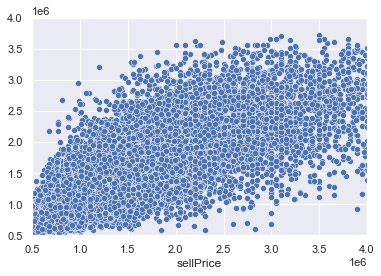



LinearRegression
-----------------
RMSE: 370111.50137377874
MAE: 260835.87298292347
The best results achieved with parameters: {}
Time: 2 seconds (0 minutes)


/opt/homebrew/anaconda3/envs/torch-nightly/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


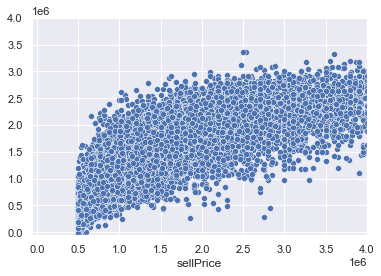

In [37]:
#Defining the pipeline to not stratify the data and to run 5 fold 3 repeat cross validation
pipe1 = Pipeline(False,3,5)
#The Expermints selected are the Random Forrest with a few parameters and Linear Regression
experiments = [{"name":"Radom Forrest",
    "model":RandomForestRegressor(n_jobs=-1, random_state=42),
    "parameters":{
        "criterion":["squared_error"],
        "max_depth":[30,80,100,200,300],
    }},
    {"name":"LinearRegression",
    "model":LinearRegression(n_jobs=-1),
    "parameters":{
    }}]
resultsML = pipe1.run_experiments_float(experiments,X=X_1_train,Y=y_1_train,Scaler=MinMaxScaler(), scoring="neg_mean_squared_error")

From the output it is visible that the Random Forrest Regressor performed better than the Linear Regression and also looking at the graphic for prediction vs actual the deviations in the Random Forrest Regressor appear to be less. It is centered more around the diagonal of the graphic. Therefor the Random Forrest Regressor has been chosen as the ML model to be benchmarked against the baseline and the NN on the test data.

Next the test data is scaled for the model and the scores will be calculated.

In [38]:
X_1_test_ML_scaled = resultsML[0]["scaler"].transform(X_1_test)
y_hat = resultsML[0]["trained_model"].predict(X_1_test_ML_scaled)
RMSE = math.sqrt(mean_squared_error(y_1_test,y_hat))
MAE = mean_absolute_error(y_1_test,y_hat)
MAPE = mean_absolute_percentage_error(y_1_test,y_hat)
Results.append({"name":resultsML[0]["name"],"scores":{"RMSE":RMSE,"MAE":MAE,"MAPE":MAPE}})

In [39]:
print(Results)

[{'name': 'baseline', 'scores': {'RMSE': 641322.4107369833, 'MAE': 486128.33970587794, 'MAPE': 0.45066580547305596}}, {'name': 'Radom Forrest', 'scores': {'RMSE': 347545.8095871557, 'MAE': 228392.31789861355, 'MAPE': 0.18015788119599177}}]


The ML model outperformed the Baseline on the basis of the test scores.

## Neuronales Netz

As last model to predict the sell price of a house Neural Networks will be trained to see if they can outperform the Machine Learning model. More specifically a Multilayer Perceptron Neural network will be used.

In [40]:
import torch
import copy

In the following section the data will be prepared so it can be inserted into the neural network.
First a Validation Dataset will be split from the training dataset in order to avoid overfitting the models. After that the training, validation and test feature datasets will be scaled. After this the dependent variable for y_train and y_val will be scaled on their own scaler. Lastly, the data will be transferred into Tensors so that they can be used in the neural network.

In [41]:

y_scaler = MinMaxScaler()
scaler = MinMaxScaler()
#shuffle not needed here as the data has been shuffled when the data was split in the first place
NN_X_1_train, NN_X_1_val, NN_y_1_train, NN_y_1_val= train_test_split(X_1_train, y_1_train, test_size = 0.2, random_state=42)
NN_X_1_train_scaled = scaler.fit_transform(NN_X_1_train)
NN_X_1_val_scaled = scaler.transform(NN_X_1_val)
NN_X_1_test_scaled = scaler.transform(X_1_test)
NN_y_1_train_scaled = y_scaler.fit_transform(NN_y_1_train.to_numpy().reshape(-1, 1))
NN_y_1_val_scaled = y_scaler.transform(NN_y_1_val.to_numpy().reshape(-1, 1))
#Generation of the Tensors that will be used for the training and prediciton 
NN_X_1_train_scaled_tensor = torch.Tensor(NN_X_1_train_scaled)
NN_X_1_val_scaled_tensor = torch.Tensor(NN_X_1_val_scaled)
NN_X_1_test_scaled_tensor = torch.Tensor(NN_X_1_test_scaled)
NN_y_1_train_tensor = torch.Tensor(NN_y_1_train_scaled)
NN_y_1_val_tensor = torch.Tensor(NN_y_1_val_scaled)

 This next function can be used to evaluate different hyperparameters for one NN and selects the best NN on the basis of the best root mean squared error on the validation dataset. RMSE was used because it will also be the criteria used later to define the best model from the three approaches Baseline, ML and DL.

In [42]:
def Grid_Search_NN(model_train, parameters, y_train,y_val, y_train_tensor_scaled,y_val_tensor_scaled,X_train_tensor,X_val_tensor, y_scaler, epochs):
    

    #https://stackoverflow.com/questions/38721847/how-to-generate-all-combination-from-values-in-dict-of-lists-in-python
    keys, values = zip(*parameters.items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

    best_rmse=float('inf')
    for combination in permutations_dicts:
        # The model is copied before the training so it is the same model that is being trained for all hyperparameters
        torch.manual_seed(42)
        model = copy.deepcopy(model_train)

        # In this section the optimizer is initialized
        if combination["optimizer"] == "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=combination["learning_rate"])
        elif combination["optimizer"] == "SGD":
            optimizer = torch.optim.SGD(model.parameters(), lr=combination["learning_rate"])
        else:
            print("Invalid Optimizer using ADAM instead")
            optimizer = torch.optim.Adam(model.parameters(), lr=combination["learning_rate"])
        
        criterion = combination["criterion"]
        print("---------------------------------------------------")
        print("Now training the model with the following parameteres:")
        for key, value in combination.items():
            print(f"{key} = {value}")
        print()
        print()
        #in this function the model training and evaluation for this specific set of hyperparamters is being conducted
        best_rmse_val, best_loss_val, best_model, best_epoch, loss_train, loss_val = training_the_model(model,y_train,y_val, y_train_tensor_scaled,y_val_tensor_scaled,X_train_tensor,X_val_tensor, optimizer, criterion, y_scaler, epochs)
        #Best model is selected on the basis of the rmse score on the validation data in the epoch with the lowest loss for the defined loss function 
        if best_rmse_val< best_rmse:
            best_rmse=best_rmse_val
            best_loss=best_loss_val
            best_model_GS = best_model
            best_epoch_GS=best_epoch
            best_params = combination
            loss_train_best = loss_train
            loss_val_best = loss_val
    #score and parameters for the selected model will be printed
    print("***************************************************************")
    print(f"The model performed best with those parameters: {best_params}")
    print(f"The best loss for the validation dataset achieved was: {best_rmse}")
    print("***************************************************************")
    return {
        "best_rmse": best_rmse,
        "best_loss": best_loss,
        "best_model": best_model_GS,
        "best_epoch": best_epoch_GS,
        "best_params": best_params,
        "loss_train_best": loss_train_best,
        "loss_val_best": loss_val_best
    }
            

The next function is the one that actually trains the neural network. It will run through the predefined epochs and select the model at the epoch where for the selected criterion (here: MAE or MSE) achieves the lowest score on the validation data. The validation dataset is being used so that the model does not overfit. This methode allows to select the optimized model for the validation data on the basis of different criterions while in the gridsearch will select the best model on the basis of the achieved RMSE on the validation dataset. 

In [43]:
def training_the_model(model,y_train,y_val, y_train_tensor_scaled,y_val_tensor_scaled,X_train_tensor,X_val_tensor, optimizer, criterion, y_scaler, epochs):
    #Aus dem Kurs angepasst
    best_loss_val=float('inf')
    best_rmse_val=float('inf')
    best_model=copy.deepcopy(model)
    best_epoch=0
    loss_train = []
    loss_val = []
    
    for epoch in range(epochs):
        model.train()
        y_train_pred = model(X_train_tensor)
        optimizer.zero_grad()
        loss_train_c = criterion(y_train_pred, y_train_tensor_scaled)
        loss_train_c.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            loss_val_c=criterion(y_val_pred, y_val_tensor_scaled)
            rmse_train = math.sqrt(mean_squared_error(y_train, y_scaler.inverse_transform(y_train_pred)))
            rmse_val= math.sqrt(mean_squared_error(y_val, y_scaler.inverse_transform(y_val_pred)))
            loss_train.append(rmse_train)
            loss_val.append(rmse_val)
            #model is selected with the lowest loss on the validation dataset
            if loss_val_c.item()< best_loss_val:
                best_rmse_val = rmse_val
                best_loss_val=loss_val_c.item()
                best_model = copy.deepcopy(model)
                best_epoch=epoch
        # Add early stop function
        if (epoch % 20==19):
            print("Epoch: %d, loss in training: %1.5f loss in val: %1.5f" % (epoch, loss_train_c.item(), loss_val_c.item()))
    return best_rmse_val, best_loss_val, best_model, best_epoch, loss_train, loss_val

Through testing Adam appears to be the best optimizer for the data so this one will be used in the following experiments. The four learning rates were selected by rule of thumb and two basic criterions have been selected to optimize the NN: MSE and MAE.

In [44]:
NN_experiments = {
    "parameters": {
        "learning_rate":[0.001, 0.005, 0.01, 0.05],
        "criterion":[ torch.nn.MSELoss(), torch.nn.L1Loss()],
        "optimizer":["Adam"]  
    }
}

Next the 3 neural nets used for this experiment are imported here. The smallest net with a maximum width of 32 and only one hidden layer was chosen as the feature size of the data is 27 and so the hidden layer is bigger compared to the input layer. Two other neural nets have been selected, one with a max width 64 with 2 hidden layers and the other with a max width of 128 and 3 hidden layers. The goal of these bigger nets is to see if they could outperform the smaller net.

The Neural Networks used belong to the group of Artificial Neural Networks, which are comprised of the input, hidden and output layers. The output gets reduced to one output as only one number is the goal of the prediction [3]. The input layer is comprised of 27 neurons as already discussed before. The architecture follows the cone shape approach where after the input layer the net reaches its max width. These are mentioned in the above text. After this the neurons get reduced by half after each layer until they reach a width of 32 neurons which are than comprised to the one neuron in the output layer. As activation function in the neural network the Rectified Linear Unit is being used. This is one of the most common ones used when developing these types of neural networks [4]. In future experiments other activation functions could be tried out, to see if they can deliver better results. However, for this preliminary research the focus will be on the Rectified Linear Unit activation function. Also drop out layers could be used in further experiments. In this experiments they will be excluded as they produced worse results in the first tryouts. 



In [45]:
from NeuralNets import NN_32_1, NN_64_2, NN_128_3

In [46]:
Models = []

The 3 architectures of the Neural Networks will be initialized in the next code box.

In [47]:
#Model initialization with random seed directly on top to guarantee it is applied in the same way to all models
torch.manual_seed(42)
Models.append(NN_32_1(NN_X_1_train_scaled_tensor.shape[1]))
torch.manual_seed(42)
Models.append(NN_64_2(NN_X_1_train_scaled_tensor.shape[1]))
torch.manual_seed(42)
Models.append(NN_128_3(NN_X_1_train_scaled_tensor.shape[1]))

In this next for loops the before defined parameters are applied to each of the Models and results for the best settings of each NN are stored.
Caution Runtime more than 35-50 min on a M1 Mac. The output is the criterion applied to the test and training data in the corresponding epoch. In the beginning of each tryout the parameters used are displayed and after each NN architecture the best parameters are printed.

In [48]:
resultsNN = []
for model in Models:
    resultsNN.append(Grid_Search_NN(model, NN_experiments["parameters"], NN_y_1_train,NN_y_1_val, NN_y_1_train_tensor,NN_y_1_val_tensor,NN_X_1_train_scaled_tensor,NN_X_1_val_scaled_tensor, y_scaler, 1400))

---------------------------------------------------
Now training the model with the following parameteres:
learning_rate = 0.001
criterion = MSELoss()
optimizer = Adam


Epoch: 19, loss in training: 0.05203 loss in val: 0.04928
Epoch: 39, loss in training: 0.02576 loss in val: 0.02538
Epoch: 59, loss in training: 0.02052 loss in val: 0.02030
Epoch: 79, loss in training: 0.01710 loss in val: 0.01702
Epoch: 99, loss in training: 0.01535 loss in val: 0.01535
Epoch: 119, loss in training: 0.01423 loss in val: 0.01428
Epoch: 139, loss in training: 0.01338 loss in val: 0.01344
Epoch: 159, loss in training: 0.01258 loss in val: 0.01264
Epoch: 179, loss in training: 0.01191 loss in val: 0.01198
Epoch: 199, loss in training: 0.01137 loss in val: 0.01147
Epoch: 219, loss in training: 0.01102 loss in val: 0.01112
Epoch: 239, loss in training: 0.01079 loss in val: 0.01090
Epoch: 259, loss in training: 0.01063 loss in val: 0.01074
Epoch: 279, loss in training: 0.01052 loss in val: 0.01063
Epoch: 29

This next part selects from the 3 models the one with the best rmse score still on the validation data.

In [49]:
#Pick the best NN on the basis of the best rmse score achieved on the validation data
winnerNN = {}
winnerNN["best_rmse"] = float('inf')
for resNN in resultsNN:
    if resNN["best_rmse"] < winnerNN["best_rmse"]:
        winnerNN = resNN
    elif resNN["best_rmse"] == winnerNN["best_rmse"]:
        print("Two models performed equally good")

In [58]:
print(resNN["best_model"])

NN_128_3(
  (hidden_1): Linear(in_features=27, out_features=128, bias=True)
  (hidden_2): Linear(in_features=128, out_features=64, bias=True)
  (hidden_3): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)


Based on the evaluation strategy the the NN with a max width of 128 neurons had the best performance on the validation dataset.

In [60]:
print(resNN["best_params"])

{'learning_rate': 0.005, 'criterion': MSELoss(), 'optimizer': 'Adam'}


As for the hyperparamters the best results were achieved when using mean squared error as loss and a learning rate of 0.005 combined with the Adam optimizer.

In this next part the best model is used to calculate the scores on the basis of the test data.

In [50]:
with torch.no_grad():
    y_test_predict = y_scaler.inverse_transform(winnerNN["best_model"](NN_X_1_test_scaled_tensor))
RMSE = math.sqrt(mean_squared_error(y_1_test,y_test_predict))
MAE = mean_absolute_error(y_1_test,y_test_predict)
MAPE = mean_absolute_percentage_error(y_1_test,y_test_predict)
Results.append({"name":"Neural Network","scores":{"RMSE":RMSE,"MAE":MAE,"MAPE":MAPE}})
Results

[{'name': 'baseline',
  'scores': {'RMSE': 641322.4107369833,
   'MAE': 486128.33970587794,
   'MAPE': 0.45066580547305596}},
 {'name': 'Radom Forrest',
  'scores': {'RMSE': 347545.8095871557,
   'MAE': 228392.31789861355,
   'MAPE': 0.18015788119599177}},
 {'name': 'Neural Network',
  'scores': {'RMSE': 331231.77090198844,
   'MAE': 219246.0813369969,
   'MAPE': 0.1730173835682141}}]

The NN outperformed the ML approach by a significant margin. Not only for the RMSE but for all 3 scores calculated.

743


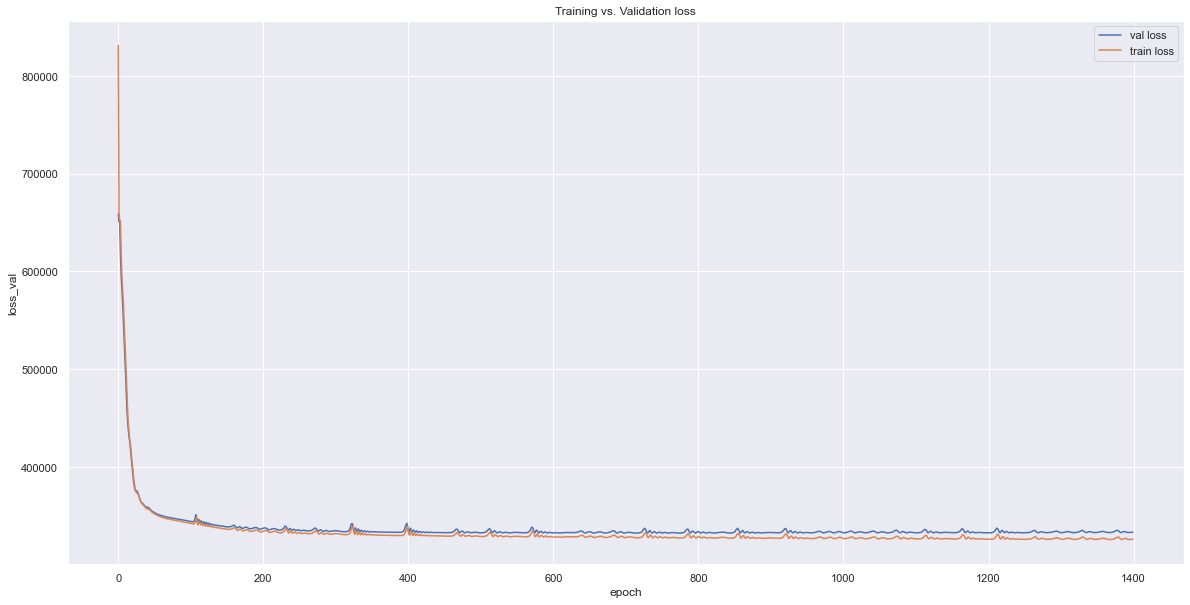

In [51]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(20,10)})
overfittingDF = pd.DataFrame()
overfittingDF["loss_train"] = winnerNN["loss_train_best"]
overfittingDF["loss_val"] = winnerNN["loss_val_best"]
print(winnerNN["best_epoch"])
sns.lineplot(data=overfittingDF, x=overfittingDF.index , y ="loss_val")
sns.lineplot(data=overfittingDF, x=overfittingDF.index , y ="loss_train", palette=["red"])
plt.legend(labels=["val loss", "train loss"])
plt.xlabel("epoch")
plt.title("Training vs. Validation loss")
plt.show()

In this first plot the training vs validation loss is displayed. The most improvement can be see within the first 150 epochs after that there are smaller improvments. towards the end the orange (training) and the blue(validation) lines separate which could be an indicator of the model overfitting in those later epochs.

743


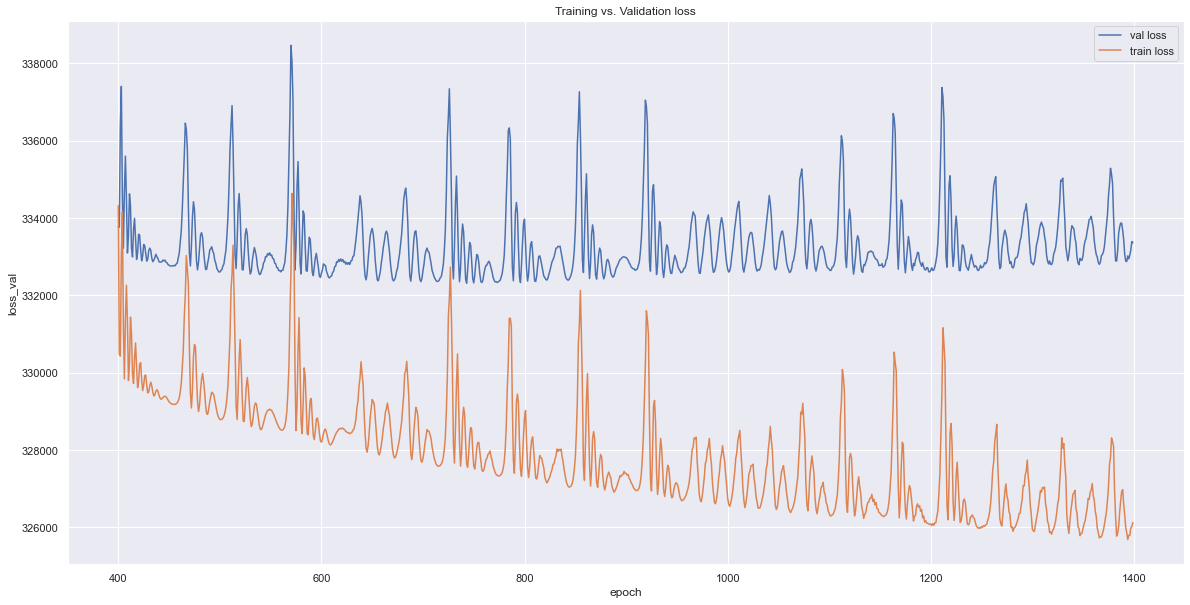

In [52]:

overfittingDF = pd.DataFrame()
overfittingDF["loss_train"] = winnerNN["loss_train_best"][400:]
overfittingDF["loss_val"] = winnerNN["loss_val_best"][400:]
print(winnerNN["best_epoch"])
sns.lineplot(data=overfittingDF, x=overfittingDF.index+400 , y ="loss_val", )
sns.lineplot(data=overfittingDF, x=overfittingDF.index+400 , y ="loss_train", palette=["red"])
plt.legend(labels=["val loss", "train loss"])
plt.xlabel("epoch")
plt.title("Training vs. Validation loss")
plt.show()

When zooming in this becomes more visable. The model improves until somewhere between 600 and 900 epochs. Or more specifically, the best score on the validation data was achieved in the epoch 743. Afterwards the score on the validation data no longer improves, it even worsens slightly. In contrast the score on the training data further improves, hinting at the NN overfitting after this point. However, the model selected, was chosen at the point with the best score on the validation data, so this presumed overfitting does not affect the final neural network.


/opt/homebrew/anaconda3/envs/torch-nightly/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


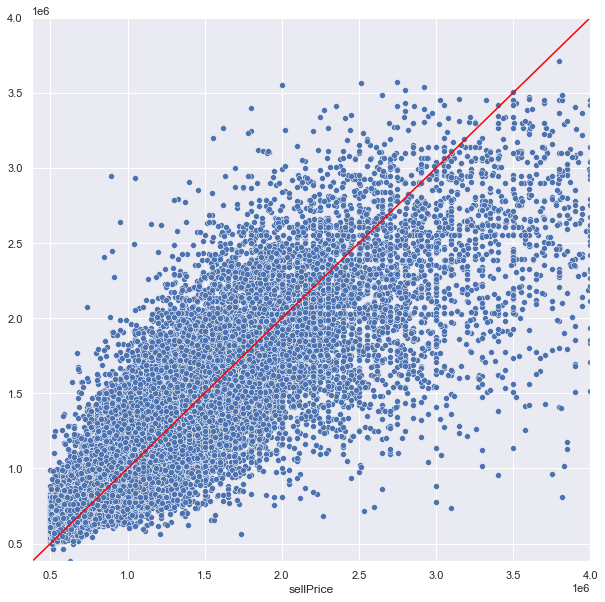

In [53]:

sns.set(rc={'figure.figsize':(10,10)})
ax = sns.scatterplot(y_1_test,np.ravel(y_test_predict))
ax.set(ylim=(min([min(y_1_test), min(np.ravel(y_test_predict))]), max([max(y_1_test), max(np.ravel(y_test_predict))])),xlim= (min([min(y_1_test), min(np.ravel(y_test_predict))]),max([max(y_1_test), max(np.ravel(y_test_predict))])))
a = [min([min(y_1_test), min(np.ravel(y_test_predict))]), max([max(y_1_test), max(np.ravel(y_test_predict))])]
sns.lineplot(x=a,y=a,color="red" )
plt.show()

This grafic shows the actual price on the x axis and the predicted price on the y axis. Ideally, all points would be on the red line. However they cluster nicely around it. This means that the NN does not constantly over or under predict the price. The deviations appear to be higher with a higher price where the NN mainly underestimates the price for the houses. 

# Conclusion

To sum all the experiments up firstly the 3 models with their prediction vs actual values will be plotted along side of each other.

/opt/homebrew/anaconda3/envs/torch-nightly/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


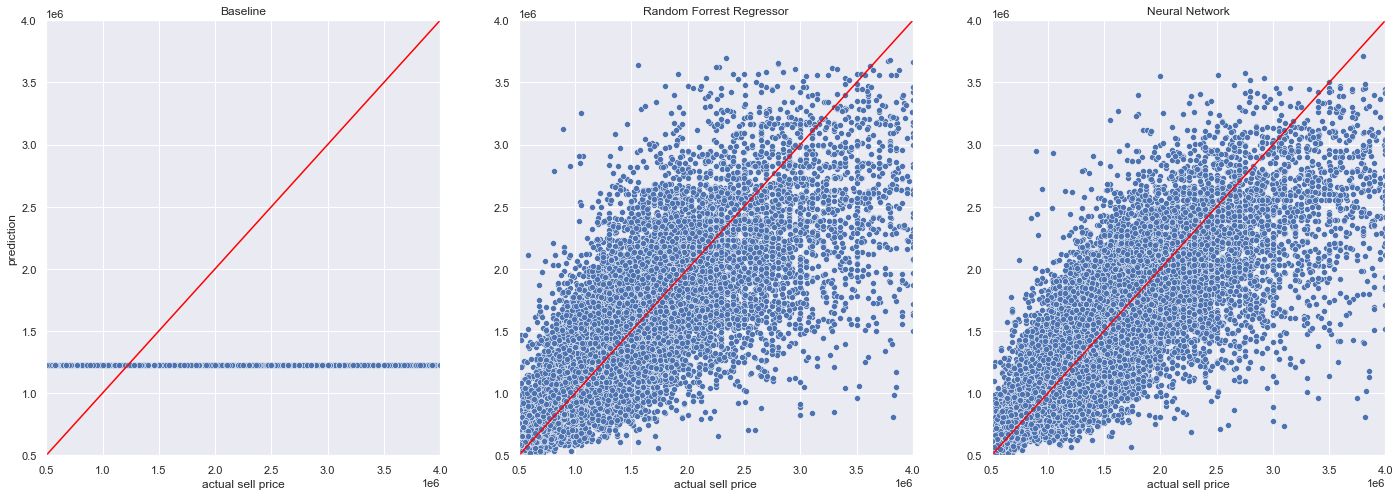

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))
low_limit = min([min(Y["sellPrice"]), min(np.ravel(Y["avgSellPrice"])), min(Y["sellPrice"]), min(Y["avgSellPrice"]), min(y_hat), min(y_1_test)])
high_limit = max([max(Y["sellPrice"]), max(np.ravel(Y["avgSellPrice"])), max(Y["sellPrice"]), max(Y["avgSellPrice"]), max(y_hat), max(y_1_test)])
a = (low_limit,high_limit)
y_hat
sns.scatterplot(x=Y["sellPrice"], y= Y["avgSellPrice"], ax=ax1)
sns.scatterplot(x=y_1_test, y= y_hat, ax=ax2)
sns.scatterplot(y_1_test,np.ravel(y_test_predict), ax= ax3)
ax1.set(ylim=a,xlim= a, title="Baseline", ylabel="prediction", xlabel="actual sell price")
ax2.set(ylim=a,xlim= a,title="Random Forrest Regressor", xlabel="actual sell price")
ax3.set(ylim=a,xlim= a,title="Neural Network", xlabel="actual sell price")
sns.lineplot(x=a,y=a,color="red", ax=ax1)
sns.lineplot(x=a,y=a,color="red", ax=ax2)
sns.lineplot(x=a,y=a,color="red",ax=ax3 )

plt.show()

The ideal here is again all points on the red line. On the left the Baseline shows as expected a straight line as only the average is used as prediction. Comparing this to the ML model one can already see a major improvement the blue points center around the redline indicating that the prediction is going in the right direction. This also explains the better results compared to the baseline. The same is true for the Neural Network. In comparison the NN has the predictions even tighter around the redline when compared to the ML model. This is the first indication that the NN performed better on the test data in comparison to the ML model. 

In [55]:
ResultsList = []
i = 0
for res in Results:
    ResultsDict= {
        "name": res["name"],
        "RMSE": res["scores"]["RMSE"],
        "MAE": res["scores"]["MAE"],
        "MAPE": res["scores"]["MAPE"]
    }
    ResultsList.append(pd.DataFrame.from_dict(ResultsDict, orient="index").transpose())

ResultsDF = pd.concat(ResultsList)
ResultsDF

,name,RMSE,MAE,MAPE
0,baseline,641322.410737,486128.339706,0.450666
0,Radom Forrest,347545.809587,228392.317899,0.180158
0,Neural Network,331231.770902,219246.081337,0.173017


The observations from the graphics also manifest themselves when looking at the scores on the test data. The baseline performed worst in all three scores and the NN performed best in all 3 scores. This means of the three models, the NN is the best in predicting the test data and should be chosen. This does not mean that the model is production ready. The average percentage error is 17.3%, this means that the actual values still deviate by roughly this percentage on average. When considering house prices this is still a lot. One of the reasons for this could be the limited dataset used to conduct this preliminary research into the feasibility of the overall project. From this perspective the results are promising and it can be concluded that a prediction of the house price is possible. 

# Outlook

What could be the next steps to get the prediction more accurate and production ready?  
Firstly, the trends in the housing market need a more in depth analysis. Unfortunately the housing market is not as steady as one might hope. There are timeseries components in the data that are important to understand, when trying to make a prediction. More time should be invested here, to get a deeper understanding and to transfer this knowledge that was gained into the models. This could greatly increase the accuracy of the prediction.    
Secondly, the data basis needs to be extended. Some basic data for the houses are missing, for example the square footage of the house and/or garden. Some categorical features like if the house has solar, AC, etc. Also there is no building year of the house which could be another factor. Also external data sources could be tied into the prediction, especially on the suburb level. Some feature could be crime rate, school rating, number of parks. One thing that is ready but could not be used and evaluated, is the dataset that does not cluster the suburbs but rather uses each single one as an individual feature. The code is already there, however, the computational time did not allow to include in this preliminary research.   
Thirdly, more models and hyper parameters could be tested and benchmarked to find better models for the price prediction. At the moment the NN appears to be the best fit, the ML models should still be further explored, especially when the dataset gets extended. Also the NN have room for improvement. One could integrate dropout layers to make the models more prone against overfitting. Different architectures as well as other activation functions could be tried to improve the results. In addition to this different loss functions could be evaluated and functions to adjust the learning rate with decreasing loss reduction could be implemented. Furthermore, other optimizers and lager nets could be tested to see if the score can be improved.    
In summary, the results from the experiments are promising and by implementing the next steps a production ready model could be developed to help your customers evaluate the price of a property offered to them. This in turn will increase the attractiveness of your market place and increase your overall number of visitors and sellers on your platform.  

[1] https://www.smh.com.au/property/news/it-s-crazy-sydney-house-prices-surge-55-per-cent-in-less-than-three-years-20220210-p59vck.html, 15.06.2022.  
[2] https://www.cnbc.com/2017/06/23/how-much-housing-prices-have-risen-since-1940.html, 15.06.2022.  
[3]https://www.analyticsvidhya.com/blog/2020/02/cnn-vs-rnn-vs-mlp-analyzing-3-types-of-neural-networks-in-deep-learning/, 15.06.2022.  
[4]https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/, 15.06.2022.  